# PCA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import time 

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## PCA from scrach

In [2]:
# サンプルデータ準備
x = np.array([3, 4, 2, 3, 4, 4, 3])
y = np.array([2, 3, 5, 5, 3, 2, 3])
X = pd.DataFrame({'x': x, 'y': y})

In [3]:
def my_pca(X, num_components):
    # 1.標準化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 2.分散共分散行列
    cov_mat = np.cov(X_scaled, rowvar=False)

    # 3.固有ベクトルと固有値
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_values = eigen_values[sorted_index]
    sorted_vectors = eigen_vectors[:, sorted_index]
    subset_vectors = sorted_vectors[:, :num_components]
    
    # 4.主成分にXを変換
    X_reduced = np.dot(X_scaled, subset_vectors)
    
    return X_reduced    

In [4]:
my_pca(X,1)

array([[-0.49467432],
       [-0.89576549],
       [ 2.34350404],
       [ 1.33314107],
       [-0.89576549],
       [-1.50503729],
       [ 0.11459748]])

## PCA from sklearn

In [5]:
# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# pca
pca = PCA(n_components=1)
pca.fit_transform(X_scaled)

array([[-0.49467432],
       [-0.89576549],
       [ 2.34350404],
       [ 1.33314107],
       [-0.89576549],
       [-1.50503729],
       [ 0.11459748]])

## PCA iris

In [6]:
# データ準備
df = sns.load_dataset('iris')

# 変数定義
y_col = 'species'
X = df.loc[:, df.columns!=y_col] #X = df.drop(columns=[y_col])でもOK
y = df[y_col].values

# 標準化
X_scaled = StandardScaler().fit_transform(X)

# pca
X_pc = PCA(n_components=2).fit_transform(X_scaled)

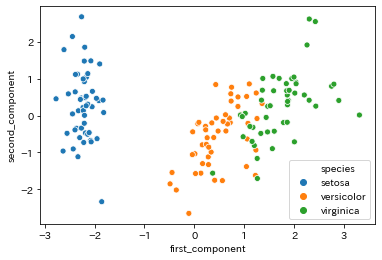

In [7]:
# 主成分分析したdfと目的変数を結合
df_pc = pd.DataFrame(np.concatenate([X_pc, y.reshape(-1,1)], axis=1)
                    ,columns = ['first_component', 'second_component', 'species'])
# 散布図
sns.scatterplot(x='first_component', y='second_component', hue='species', data=df_pc)

## 累積寄与率

In [8]:
# pca
n_components = 4
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=4)

In [9]:
# 寄与率
pca.explained_variance_ratio_

array([0.72962445, 0.22850762, 0.03668922, 0.00517871])

Text(0.5, 1.0, '累積寄与率')

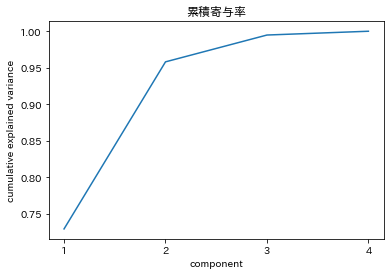

In [10]:
# 累積寄与率描画
x = range(1, n_components + 1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.plot(x,y)
# x軸整数化
plt.xticks(x)
# ラベル定義
plt.xlabel('component')
plt.ylabel('cumulative explained variance')
# タイトル
plt.title('累積寄与率')

## PCA on MNIST

In [11]:
mnist = fetch_openml('mnist_784')

In [12]:
# df変換
mnist_data = pd.DataFrame(mnist.data, columns=mnist.feature_names)

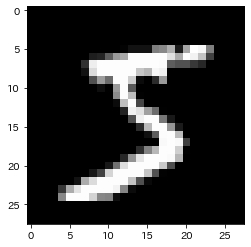

In [13]:
# 画像の再構成
# 28×28配列に変換
mnist_data_im = mnist_data.iloc[0].values.reshape(28, 28)
plt.imshow(mnist_data_im, 'gray')

In [14]:
# hold-out
X = mnist_data
y = mnist.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [15]:
# 標準化
scaler = StandardScaler()
scaler.fit(X_train)
# 学習データ
X_train_scaled = scaler.transform(X_train)
# テストデータ（学習データの平均・標準偏差で標準化）
X_test_scaled = scaler.fit_transform(X_test)

In [16]:
# PCA
pca = PCA(n_components=0.95)
pca.fit(X_train_scaled)

X_train_pc = pca.transform(X_train_scaled)
X_test_pc = pca.transform(X_test_scaled)

print(f'{X_train.shape[-1]} dimensions is reduced to {X_train_pc.shape[-1]} dimension by PCA')

784 dimensions is reduced to 323 dimension by PCA


In [17]:
# 学習（PCAあり）
model_pca = LogisticRegression(penalty='none', multi_class='multinomial')

before = time.time()
model_pca.fit(X_train_pc, y_train)
after = time.time()

print(f'fit took {after - before:.2f}s')

# 予測
y_pred_pc = model_pca.predict(X_test_pc)
y_pred_pc_proba = model_pca.predict_proba(X_test_pc)

fit took 7.50s


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [18]:
accuracy_score(y_test, y_pred_pc)

0.9198571428571428

In [19]:
# 学習（PCAなし）
model = LogisticRegression(penalty='none', multi_class='multinomial')

before = time.time()
model.fit(X_train_scaled, y_train)
after = time.time()

print(f'fit took {after - before:.2f}s')

# 予測
y_pred_pc = model.predict(X_test_scaled)
y_pred_pc_proba = model.predict_proba(X_test_scaled)

fit took 14.38s


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [20]:
accuracy_score(y_test, y_pred_pc)

0.9102380952380953

Text(0.5, 1.0, '累積寄与率')

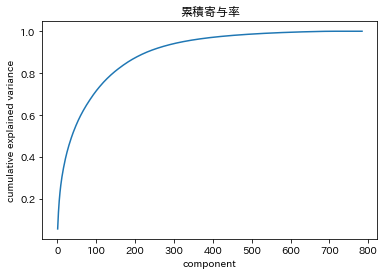

In [21]:
# 累積寄与率描画
pca = PCA()
pca.fit(X_train_scaled)

x = range(1, len(pca.explained_variance_ratio_) + 1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.plot(x,y)
# ラベル定義
plt.xlabel('component')
plt.ylabel('cumulative explained variance')
# タイトル
plt.title('累積寄与率')